Image chargée: 2x2 pixels


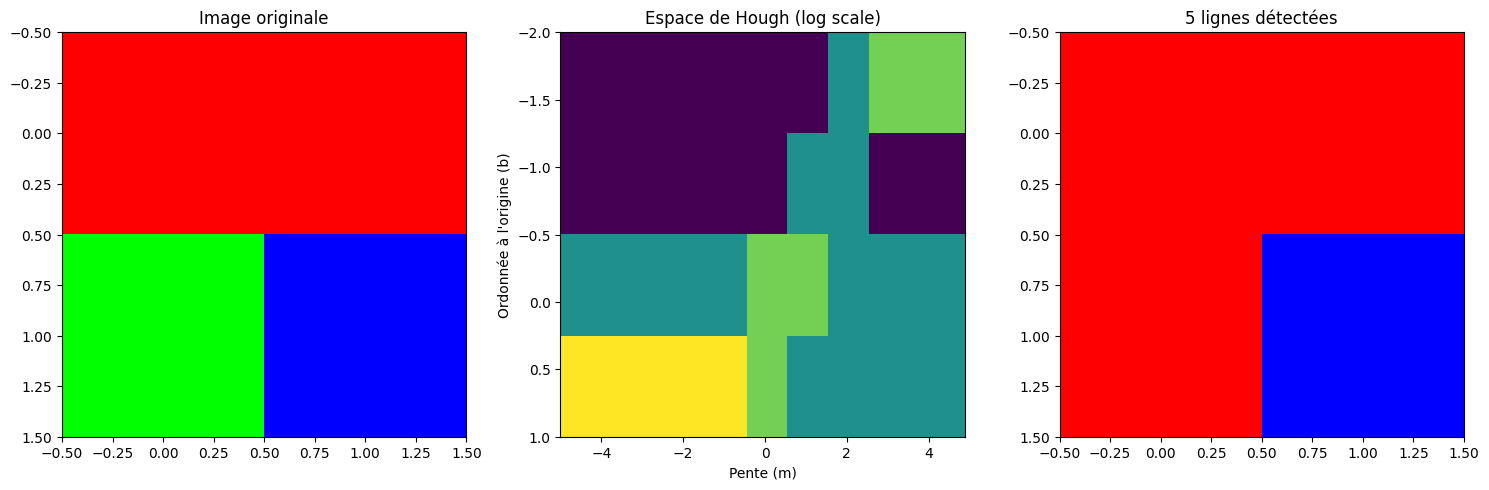


Lignes détectées (équation y = mx + b):
Ligne 1: y = -1.40x + 1.00
Ligne 2: y = -0.90x + 1.00
Ligne 3: y = -1.00x + 1.00
Ligne 4: y = -1.10x + 1.00
Ligne 5: y = -1.20x + 1.00


In [3]:
import numpy as np
import matplotlib.pyplot as plt

def lire_entete_ppm(fichier):
    """
    Lit l'en-tête d'un fichier PPM (format P3)
    Retourne la largeur, hauteur et la valeur maximale
    """
    lignes = []
    while len(lignes) < 3:
        ligne = fichier.readline()
        if not ligne.startswith(b'#'):  # Ignorer les commentaires
            lignes.append(ligne)
    
    if lignes[0].strip() != b'P3':
        raise ValueError("Format PPM invalide. Doit commencer par P3")
    
    dimensions = lignes[1].strip().split()
    largeur, hauteur = int(dimensions[0]), int(dimensions[1])
    val_max = int(lignes[2].strip())
    
    return largeur, hauteur, val_max

def charger_image_ppm(chemin):
    """
    Charge une image PPM (format P3) et retourne un tableau numpy
    Format de retour: (hauteur, largeur, 3) avec les canaux RGB
    """
    with open(chemin, 'rb') as f:
        largeur, hauteur, val_max = lire_entete_ppm(f)
        
        donnees = []
        for ligne in f:
            if ligne.startswith(b'#'):
                continue
            for val in ligne.strip().split():
                donnees.append(int(val))
    
    image = np.array(donnees, dtype=np.uint8)
    return image.reshape((hauteur, largeur, 3))

def transformer_hough_naive(image, pas_m=0.1, pas_b=1):
    """
    Implémentation naïve de la transformée de Hough pour y = mx + b
    """
    # Conversion en niveaux de gris
    if len(image.shape) == 3:
        image = np.mean(image, axis=2)
    
    # Seuillage pour détecter les contours
    seuil = 0.5 * np.max(image)
    image_binaire = (image > seuil).astype(np.uint8)
    
    hauteur, largeur = image_binaire.shape
    
    # Plages pour m et b
    m_min, m_max = -5, 5
    b_min, b_max = -hauteur, hauteur
    
    m_values = np.arange(m_min, m_max, pas_m)
    b_values = np.arange(b_min, b_max, pas_b)
    
    accumulateur = np.zeros((len(b_values), len(m_values)), dtype=np.uint64)
    
    y_idxs, x_idxs = np.nonzero(image_binaire)
    
    for x, y in zip(x_idxs, y_idxs):
        for m_idx, m in enumerate(m_values):
            b = y - m * x
            b_idx = np.argmin(np.abs(b_values - b))
            if 0 <= b_idx < len(b_values):
                accumulateur[b_idx, m_idx] += 1
    
    return accumulateur, m_values, b_values

def trouver_maxima(accumulateur, m_values, b_values, nb_lignes=5):
    """
    Trouve les maxima dans l'accumulateur de Hough
    """
    indices = np.argpartition(accumulateur.flatten(), -nb_lignes)[-nb_lignes:]
    lignes = []
    
    for idx in indices:
        b_idx = idx // accumulateur.shape[1]
        m_idx = idx % accumulateur.shape[1]
        m = m_values[m_idx]
        b = b_values[b_idx]
        lignes.append((m, b, accumulateur[b_idx, m_idx]))
    
    lignes.sort(key=lambda x: x[2], reverse=True)
    return [(m, b) for m, b, score in lignes]

def dessiner_ligne_bresenham(image, x0, y0, x1, y1, couleur=(255, 0, 0)):
    """
    Trace une ligne avec l'algorithme de Bresenham
    """
    dx = abs(x1 - x0)
    dy = abs(y1 - y0)
    steep = dy > dx
    
    if steep:
        x0, y0 = y0, x0
        x1, y1 = y1, x1
    
    if x0 > x1:
        x0, x1 = x1, x0
        y0, y1 = y1, y0
    
    dx = x1 - x0
    dy = abs(y1 - y0)
    erreur = dx // 2
    y_step = 1 if y0 < y1 else -1
    y = y0
    
    for x in range(x0, x1 + 1):
        if steep:
            if 0 <= x < image.shape[0] and 0 <= y < image.shape[1]:
                image[x, y] = couleur
        else:
            if 0 <= x < image.shape[1] and 0 <= y < image.shape[0]:
                image[y, x] = couleur
        
        erreur -= dy
        if erreur < 0:
            y += y_step
            erreur += dx

def dessiner_lignes(image, lignes):
    """
    Dessine les lignes détectées sur l'image
    """
    if len(image.shape) == 2:
        image_couleur = np.stack([image]*3, axis=-1)
    else:
        image_couleur = image.copy()
    
    hauteur, largeur = image_couleur.shape[:2]
    
    for m, b in lignes:
        x1 = 0
        y1 = int(m * x1 + b)
        x2 = largeur - 1
        y2 = int(m * x2 + b)
        
        y1 = max(0, min(hauteur-1, y1))
        y2 = max(0, min(hauteur-1, y2))
        
        dessiner_ligne_bresenham(image_couleur, x1, y1, x2, y2)
    
    return image_couleur

def tester_detection_lignes(chemin_image, nb_lignes=5):
    """
    Fonction principale pour tester la détection de lignes
    """
    try:
        # Charger l'image
        image = charger_image_ppm(chemin_image)
        print(f"Image chargée: {image.shape[1]}x{image.shape[0]} pixels")
        
        # Appliquer la transformée de Hough
        accumulateur, m_values, b_values = transformer_hough_naive(image)
        
        # Trouver les lignes principales
        lignes = trouver_maxima(accumulateur, m_values, b_values, nb_lignes)
        
        # Dessiner les lignes sur l'image
        image_resultat = dessiner_lignes(image, lignes)
        
        # Afficher les résultats
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 3, 1)
        plt.imshow(image)
        plt.title("Image originale")
        
        plt.subplot(1, 3, 2)
        plt.imshow(np.log(accumulateur + 1), aspect='auto', 
                  extent=[m_values[0], m_values[-1], b_values[-1], b_values[0]])
        plt.title("Espace de Hough (log scale)")
        plt.xlabel("Pente (m)")
        plt.ylabel("Ordonnée à l'origine (b)")
        
        plt.subplot(1, 3, 3)
        plt.imshow(image_resultat)
        plt.title(f"{nb_lignes} lignes détectées")
        
        plt.tight_layout()
        plt.show()
        
        print("\nLignes détectées (équation y = mx + b):")
        for i, (m, b) in enumerate(lignes, 1):
            print(f"Ligne {i}: y = {m:.2f}x + {b:.2f}")
            
    except FileNotFoundError:
        print(f"Erreur: Fichier {chemin_image} introuvable")
    except Exception as e:
        print(f"Erreur: {str(e)}")

# Exécution du test avec image
if __name__ == "__main__":
   
    nom_fichier = "imgTresSimple.ppm"
    
    # Tester la détection de lignes
    tester_detection_lignes(nom_fichier, nb_lignes=5)